# Task description
- Classify the speakers of given features.
- Main goal: Learn how to use transformer.
- Baselines:
  - Easy: Run sample code and know how to use transformer.
  - Medium: Know how to adjust parameters of transformer.
  - Strong: Construct [conformer](https://arxiv.org/abs/2005.08100) which is a variety of transformer. 
  - Boss: Implement [Self-Attention Pooling](https://arxiv.org/pdf/2008.01077v1.pdf) & [Additive Margin Softmax](https://arxiv.org/pdf/1801.05599.pdf) to further boost the performance.

- Other links
  - Kaggle: [link](https://www.kaggle.com/t/ac77388c90204a4c8daebeddd40ff916)
  - Slide: [link](https://docs.google.com/presentation/d/1HLAj7UUIjZOycDe7DaVLSwJfXVd3bXPOyzSb6Zk3hYU/edit?usp=sharing)
  - Data: [link](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

# Download dataset
- Data is [here](https://drive.google.com/drive/folders/1vI1kuLB-q1VilIftiwnPOCAeOOFfBZge?usp=sharing)

In [17]:
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partaa
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partab
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partac
# !wget https://github.com/MachineLearningHW/ML_HW4_Dataset/releases/latest/download/Dataset.tar.gz.partad

# !cat Dataset.tar.gz.part* > Dataset.tar.gz

# unzip the file
# !tar zxvf Dataset.tar.gz

## Fix Random Seed

In [18]:
import numpy as np
import torch
import random

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(87)

# Data

## Dataset
- Original dataset is [Voxceleb2](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox2.html).
- The [license](https://creativecommons.org/licenses/by/4.0/) and [complete version](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/files/license.txt) of Voxceleb2.
- We randomly select 600 speakers from Voxceleb2.
- Then preprocess the raw waveforms into mel-spectrograms.

- Args:
  - data_dir: The path to the data directory.
  - metadata_path: The path to the metadata.
  - segment_len: The length of audio segment for training. 
- The architecture of data directory \\
  - data directory \\
  |---- metadata.json \\
  |---- testdata.json \\
  |---- mapping.json \\
  |---- uttr-{random string}.pt \\

- The information in metadata
  - "n_mels": The dimention of mel-spectrogram.
  - "speakers": A dictionary. 
    - Key: speaker ids.
    - value: "feature_path" and "mel_len"


For efficiency, we segment the mel-spectrograms into segments in the traing step.

In [19]:
import os
import json
import torch
import random
from pathlib import Path
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
 
 
class myDataset(Dataset):
	def __init__(self, data_dir, segment_len=128):
		self.data_dir = data_dir
		self.segment_len = segment_len
	
		# Load the mapping from speaker neme to their corresponding id. 
		mapping_path = Path(data_dir) / "mapping.json"
		mapping = json.load(mapping_path.open())
		self.speaker2id = mapping["speaker2id"]
	
		# Load metadata of training data.
		metadata_path = Path(data_dir) / "metadata.json"
		metadata = json.load(open(metadata_path))["speakers"]
	
		# Get the total number of speaker.
		self.speaker_num = len(metadata.keys())
		self.data = []
		for speaker in metadata.keys():
			for utterances in metadata[speaker]:
				self.data.append([utterances["feature_path"], self.speaker2id[speaker]])
 
	def __len__(self):
			return len(self.data)
 
	def __getitem__(self, index):
		feat_path, speaker = self.data[index]
		# Load preprocessed mel-spectrogram.
		mel = torch.load(os.path.join(self.data_dir, "uttrs" ,feat_path))

		# Segmemt mel-spectrogram into "segment_len" frames.
		if len(mel) > self.segment_len:
			# Randomly get the starting point of the segment.
			start = random.randint(0, len(mel) - self.segment_len)
			# Get a segment with "segment_len" frames.
			mel = torch.FloatTensor(mel[start:start+self.segment_len])
		else:
			mel = torch.FloatTensor(mel)
		# Turn the speaker id into long for computing loss later.
		speaker = torch.FloatTensor([speaker]).long()
		return mel, speaker
 
	def get_speaker_number(self):
		return self.speaker_num

## Dataloader
- Split dataset into training dataset(90%) and validation dataset(10%).
- Create dataloader to iterate the data.

In [20]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


def collate_batch(batch):
	# Process features within a batch.
	"""Collate a batch of data."""
	mel, speaker = zip(*batch)
	# Because we train the model batch by batch, we need to pad the features in the same batch to make their lengths the same.
	mel = pad_sequence(mel, batch_first=True, padding_value=1e-20)    # pad log 10^(-20) which is very small value.
	# mel: (batch size, length, 40)
	return mel, torch.FloatTensor(speaker).long()


def get_dataloader(data_dir, batch_size, n_workers, **kwargs):
	"""Generate dataloader"""
	dataset = myDataset(data_dir, **kwargs)
	speaker_num = dataset.get_speaker_number()
	# Split dataset into training dataset and validation dataset
	trainlen = int(0.9 * len(dataset))
	lengths = [trainlen, len(dataset) - trainlen]
	trainset, validset = random_split(dataset, lengths)

	train_loader = DataLoader(
		trainset,
		batch_size=batch_size,
		shuffle=True,
		drop_last=True,
		num_workers=n_workers,
		pin_memory=True,
		collate_fn=collate_batch,
	)
	valid_loader = DataLoader(
		validset,
		batch_size=batch_size,
		num_workers=n_workers,
		drop_last=True,
		pin_memory=True,
		collate_fn=collate_batch,
	)

	return train_loader, valid_loader, speaker_num

# Model
- TransformerEncoderLayer:
  - Base transformer encoder layer in [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
  - Parameters:
    - d_model: the number of expected features of the input (required).

    - nhead: the number of heads of the multiheadattention models (required).

    - dim_feedforward: the dimension of the feedforward network model (default=2048).

    - dropout: the dropout value (default=0.1).

    - activation: the activation function of intermediate layer, relu or gelu (default=relu).

- TransformerEncoder:
  - TransformerEncoder is a stack of N transformer encoder layers
  - Parameters:
    - encoder_layer: an instance of the TransformerEncoderLayer() class (required).

    - num_layers: the number of sub-encoder-layers in the encoder (required).

    - norm: the layer normalization component (optional).

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Classifier(nn.Module):
	def __init__(self, d_model=80, nhead=2, encoder_layers=1, n_spks=600, dropout=0.1):
		super().__init__()
		# Project the dimension of features from that of input into d_model.
		self.prenet = nn.Linear(40, d_model)
		# TODO:
		#   Change Transformer to Conformer.
		#   https://arxiv.org/abs/2005.08100
		self.encoder_layer = nn.TransformerEncoderLayer(
			d_model=d_model, dim_feedforward=256, nhead=nhead
		)
		self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=encoder_layers)

		# Project the the dimension of features from d_model into speaker nums.
		self.pred_layer = nn.Sequential(
			# nn.Linear(d_model, d_model),
			# nn.ReLU(),
			nn.Linear(d_model, n_spks),
		)

	def forward(self, mels):
		"""
		args:
			mels: (batch size, length, 40)
		return:
			out: (batch size, n_spks)
		"""
		# out: (batch size, length, d_model)
		out = self.prenet(mels)
		# out: (length, batch size, d_model)
		out = out.permute(1, 0, 2)
		# The encoder layer expect features in the shape of (length, batch size, d_model).
		out = self.encoder(out)
		# out: (batch size, length, d_model)
		out = out.transpose(0, 1)
		# mean pooling
		stats = out.mean(dim=1)

		# # max pooling
		# stats = torch.amax(out, dim=1)

		# out: (batch, n_spks)
		out = self.pred_layer(stats)
		return out
	
print(Classifier())

Classifier(
  (prenet): Linear(in_features=40, out_features=80, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=True)
    )
    (linear1): Linear(in_features=80, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=80, bias=True)
    (norm1): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((80,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=80, out_features=80, bias=True)
        )
        (linear1): Linear(in_features=80, out_features=256, bias=True)
        (dropout): Dro

In [22]:
# Comformer Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.transpose(*self.shape)

class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs):
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)
    
class FeedForwardModule(nn.Module):
    """
    Feed Forward Module.
    """
    def __init__(self, d_model, dropout: float = 0.1):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, inputs):
        return self.sequential(inputs)
    
class ConvolutionModule(nn.Module):
    """
    Convolution Module.
    """
    def __init__(self, d_model, kernel_size: int = 31, dropout: float = 0.1):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(d_model),          # (batch, length, d_model) -> (batch, length, d_model)
            Transpose(shape=(1, 2)),        # (batch, length, d_model) -> (batch, d_model, length)
            nn.Conv1d(d_model, d_model, kernel_size, padding=(kernel_size - 1) // 2),
            # (batch, d_model, length) -> (batch, d_model, length)
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            Transpose(shape=(1, 2)),        #  (batch, d_model, length) -> (batch, length, d_model)
        )

    def forward(self, inputs):
        return self.sequential(inputs)

class ComformerBlock(nn.Module):
    def __init__(self, d_model=80, nhead=2, encoder_layers=1, n_spks=600, dropout=0.1):
        super().__init__()

        self.feed_forward_1 = ResidualConnectionModule(
            FeedForwardModule(
                d_model=d_model,
                dropout=dropout
            ),
            module_factor=0.5
        )
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, dim_feedforward=256, nhead=nhead, batch_first=True
            ),
            num_layers=encoder_layers
        )

        self.conv = ResidualConnectionModule(
            ConvolutionModule(
                d_model=d_model,
                dropout=dropout
            ),
            
        )

        self.feed_forward_2 = ResidualConnectionModule(
            FeedForwardModule(
                d_model=d_model,
                dropout=dropout
            ),
            module_factor=0.5
        )

    def forward(self, mels):
        """
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_spks)
        """
        # out: (batch size, length, d_model)
        out = self.feed_forward_1(mels)
        out = self.encoder(out)
        out = self.conv(out)
        out = self.feed_forward_2(out)
        
        return out

class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        # self.W = nn.Linear(input_dim, 1, bias=False)
        self.W = torch.nn.Parameter(torch.empty(input_dim, 1), requires_grad=True)
        torch.nn.init.xavier_uniform_(self.W)
        
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        
        attention_weight:
            att_w : size (N, T, 1)
        
        return:
            utter_rep: size (N, H)

        """
        # att_w = nn.functional.softmax(self.W(batch_rep), dim=1)
        att_w = nn.functional.softmax(batch_rep @ self.W, dim=1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)

        return utter_rep


class Comformer(nn.Module):
    def __init__(self, d_model=80, nhead=2, comformer_layers=1, n_spks=600, dropout=0.1, pred_layer=True, norm_after_cf_block=True):
        super().__init__()

        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)

        self.prenet_drop = nn.Dropout(dropout)

        self.layers = nn.ModuleList([ComformerBlock(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            n_spks=n_spks
        ) for _ in range(comformer_layers)])

        self.post_comformer_drop = nn.Dropout(dropout)

        self.self_attention_pooling = SelfAttentionPooling(d_model)

        self.self_attention_pooling_drop = nn.Dropout(dropout)

        if norm_after_cf_block:
            self.layer_norm = nn.LayerNorm(d_model)
        else:
            self.layer_norm = nn.Identity()

        if pred_layer:
            self.pred_layer = nn.Sequential(
                nn.Linear(d_model, d_model),
                nn.ReLU()
            )
        else:
            self.pred_layer = nn.Identity()

    def forward(self, mels):

        out = self.prenet(mels)

        out = self.prenet_drop(out)

        for layer in self.layers:
            out = layer(out)

        out = self.post_comformer_drop(out)

        out = self.layer_norm(out)

        # mean pooling
        # stats = out.mean(dim=1)

        # self attention pooling
        stats = self.self_attention_pooling(out)

        stats = self.self_attention_pooling_drop(stats)

        # out: (batch, n_spks)
        out = self.pred_layer(stats)

        return out

# comformer = Comformer(d_model=240, nhead=6, encoder_layers=1, n_spks=600).to("cuda")
# print(summary(comformer, (128, 40)))

In [23]:
# Comformer2 Implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Transpose(nn.Module):
    """ Wrapper class of torch.transpose() for Sequential module. """
    def __init__(self, shape: tuple):
        super(Transpose, self).__init__()
        self.shape = shape

    def forward(self, x):
        return x.transpose(*self.shape)

class ResidualConnectionModule(nn.Module):
    """
    Residual Connection Module.
    outputs = (module(inputs) x module_factor + inputs x input_factor)
    """
    def __init__(self, module: nn.Module, module_factor: float = 1.0, input_factor: float = 1):
        super(ResidualConnectionModule, self).__init__()
        self.module = module
        self.module_factor = module_factor
        self.input_factor = input_factor

    def forward(self, inputs):
        return (self.module(inputs) * self.module_factor) + (inputs * self.input_factor)
    
class FeedForwardModule2(nn.Module):
    """
    Feed Forward Module.
    """
    def __init__(self, d_model, dropout: float = 0.1):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
        )

    def forward(self, inputs):
        return self.sequential(inputs)
    
class ConvolutionModule(nn.Module):
    """
    Convolution Module.
    """
    def __init__(self, d_model, kernel_size: int = 31, dropout: float = 0.1):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.LayerNorm(d_model),          # (batch, length, d_model) -> (batch, length, d_model)
            Transpose(shape=(1, 2)),        # (batch, length, d_model) -> (batch, d_model, length)
            nn.Conv1d(d_model, d_model * 2, 1),
            nn.GLU(1),
            nn.Conv1d(d_model, d_model, kernel_size, padding=(kernel_size - 1) // 2, groups=d_model),
            # (batch, d_model, length) -> (batch, d_model, length)
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Conv1d(d_model, d_model, 1),
            nn.Dropout(dropout),
            Transpose(shape=(1, 2)),        #  (batch, d_model, length) -> (batch, length, d_model)
        )

    def forward(self, inputs):
        return self.sequential(inputs)

class ComformerBlock2(nn.Module):
    def __init__(self, d_model=80, nhead=2, encoder_layers=1, n_spks=600, dropout=0.1):
        super().__init__()

        self.feed_forward_1 = ResidualConnectionModule(
            FeedForwardModule2(
                d_model=d_model,
                dropout=dropout
            ),
            module_factor=0.5
        )
        
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, dim_feedforward=256, nhead=nhead, batch_first=True
            ),
            num_layers=encoder_layers
        )

        self.conv = ResidualConnectionModule(
            ConvolutionModule(
                d_model=d_model,
                dropout=dropout
            ),
            
        )

        self.feed_forward_2 = ResidualConnectionModule(
            FeedForwardModule2(
                d_model=d_model,
                dropout=dropout
            ),
            module_factor=0.5
        )

    def forward(self, mels):
        """
        args:
            mels: (batch size, length, 40)
        return:
            out: (batch size, n_spks)
        """
        # out: (batch size, length, d_model)
        out = self.feed_forward_1(mels)
        out = self.encoder(out)
        out = self.conv(out)
        out = self.feed_forward_2(out)
        
        return out

class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling 
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        # self.W = nn.Linear(input_dim, 1, bias=False)
        self.W = torch.nn.Parameter(torch.empty(input_dim, 1), requires_grad=True)
        torch.nn.init.xavier_uniform_(self.W)
        
    def forward(self, batch_rep):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        
        attention_weight:
            att_w : size (N, T, 1)
        
        return:
            utter_rep: size (N, H)

        """
        # att_w = nn.functional.softmax(self.W(batch_rep), dim=1)
        att_w = nn.functional.softmax(batch_rep @ self.W, dim=1)
        utter_rep = torch.mean(batch_rep * att_w, dim=1)

        return utter_rep


class Comformer2(nn.Module):
    def __init__(self, d_model=80, nhead=2, comformer_layers=1, n_spks=600, dropout=0.1, pred_layer=0, norm_after_cf_block=True):
        super().__init__()

        # Project the dimension of features from that of input into d_model.
        self.prenet = nn.Linear(40, d_model)

        self.prenet_drop = nn.Dropout(dropout)

        self.layers = nn.ModuleList([ComformerBlock2(
            d_model=d_model,
            nhead=nhead,
            dropout=dropout,
            n_spks=n_spks
        ) for _ in range(comformer_layers)])

        self.post_comformer_drop = nn.Dropout(dropout)

        self.self_attention_pooling = SelfAttentionPooling(d_model)

        self.self_attention_pooling_drop = nn.Dropout(dropout)

        if norm_after_cf_block:
            self.layer_norm = nn.LayerNorm(d_model)
        else:
            self.layer_norm = nn.Identity()

        if pred_layer > 0:
            self.pred_layers = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(d_model, d_model),
                    nn.ReLU()
                ) for _ in range(pred_layer)]
            )
        else:
            self.pred_layers = nn.ModuleList([nn.Identity()])

    def forward(self, mels):

        out = self.prenet(mels)

        out = self.prenet_drop(out)

        for layer in self.layers:
            out = layer(out)

        out = self.post_comformer_drop(out)

        out = self.layer_norm(out)

        # mean pooling
        # stats = out.mean(dim=1)

        # self attention pooling
        stats = self.self_attention_pooling(out)

        stats = self.self_attention_pooling_drop(stats)

        # out: (batch, n_spks)
        for pred_layer in self.pred_layers:
            stats = pred_layer(stats)
            
        return stats



In [24]:
import torch
from conformer import Conformer as RealComformer

class RComformer(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.comformer = RealComformer(*args, **kwargs)
        self.input_lengths = torch.full((32, ), 128, device="cuda", dtype=torch.long)

    def forward(self, mels):
        out, _ = self.comformer(mels, self.input_lengths)
        stats = out.mean(dim=1)

        return stats

# Learning rate schedule
- For transformer architecture, the design of learning rate schedule is different from that of CNN.
- Previous works show that the warmup of learning rate is useful for training models with transformer architectures.
- The warmup schedule
  - Set learning rate to 0 in the beginning.
  - The learning rate increases linearly from 0 to initial learning rate during warmup period.

In [34]:
import math

import torch
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR


def get_cosine_schedule_with_warmup(
	optimizer: Optimizer,
	num_warmup_steps: int,
	num_training_steps: int,
	num_cycles: float = 0.5,
	last_epoch: int = -1,
):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

def get_cosine_schedule(
	optimizer: Optimizer,
	num_training_steps: int,
	num_cycles: float = 0.5,
	last_epoch: int = -1,
):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		progress = float(current_step) / float(
			max(1, num_training_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

def get_exp_schedule_with_warmup(
	optimizer: Optimizer,
	num_warmup_steps: int,
	num_training_steps: int,
	decay_const: float = 2.5,
	last_epoch: int = -1,
):
	"""
	Create a schedule with a learning rate that decreases following the values of the cosine function between the
	initial lr set in the optimizer to 0, after a warmup period during which it increases linearly between 0 and the
	initial lr set in the optimizer.

	Args:
		optimizer (:class:`~torch.optim.Optimizer`):
		The optimizer for which to schedule the learning rate.
		num_warmup_steps (:obj:`int`):
		The number of steps for the warmup phase.
		num_training_steps (:obj:`int`):
		The total number of training steps.
		num_cycles (:obj:`float`, `optional`, defaults to 0.5):
		The number of waves in the cosine schedule (the defaults is to just decrease from the max value to 0
		following a half-cosine).
		last_epoch (:obj:`int`, `optional`, defaults to -1):
		The index of the last epoch when resuming training.

	Return:
		:obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
	"""
	def lr_lambda(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, math.exp(-decay_const * progress)
		)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

def get_transformer_scheduler(
	optimizer: Optimizer,
	num_warmup_steps: int,
	last_epoch: int = -1,
):

	def lr_lambda(current_step):
		step = current_step + 1
		return min(step**(-0.5), step * num_warmup_steps**(-1.5)) / num_warmup_steps**(-0.5)
	
	return LambdaLR(optimizer, lr_lambda, last_epoch)
	
def get_transformer_milestone_scheduler(
	optimizer: Optimizer,
	num_warmup_steps: int,
	switch_to_milestone_steps: int,
	milestones: int = 5000,
	milestone_decay_rate: float = 0.7,
	min_lr: float = 0.01,
	last_epoch: int = -1,
):
	def lr_lambda(current_step):
		if current_step < switch_to_milestone_steps:
			step = current_step + 1
			return min(step**(-0.5), step * num_warmup_steps**(-1.5)) / num_warmup_steps**(-0.5)
		else:
			return max(switch_to_milestone_steps**(-0.5) / num_warmup_steps**(-0.5) * (milestone_decay_rate ** ((current_step - switch_to_milestone_steps) // milestones + 1)), min_lr)

	return LambdaLR(optimizer, lr_lambda, last_epoch)

In [26]:
import matplotlib.pyplot as plt

num_warmup_steps = 1000
num_training_steps = 70000
decay_const = 2.5

def lr_lambda_exp(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, math.exp(-decay_const * progress)
		)

num_cycles = 0.425

def lr_lambda_sin(current_step):
		# Warmup
		if current_step < num_warmup_steps:
			return float(current_step) / float(max(1, num_warmup_steps))
		# decadence
		progress = float(current_step - num_warmup_steps) / float(
			max(1, num_training_steps - num_warmup_steps)
		)
		return max(
			0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))
		)

switch_to_milestone_steps = 40000
milestones = 1000
milestone_decay_rate = 0.7

def transform_lr(current_step):
	if current_step < switch_to_milestone_steps:
		step = current_step + 1
		return min(step**(-0.5), step * num_warmup_steps**(-1.5)) / num_warmup_steps**(-0.5)
	else:
		return max(switch_to_milestone_steps**(-0.5) / num_warmup_steps**(-0.5) * (milestone_decay_rate ** ((current_step - switch_to_milestone_steps) // milestones + 1)), 0.01)

x = [i for i in range(70000)]
y1 = [lr_lambda_exp(i) for i in x]
y2 = [lr_lambda_sin(i) for i in x]
y3 = [transform_lr(i + 1) for i in x]

# plt.plot(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)

# Additive Margin Softmax Loss Function

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AMSoftmax(nn.Module):
    # https://github.com/CoinCheung/pytorch-loss
    def __init__(self,
                 in_feats,
                 n_classes=10,
                 feat_norm=False,
                 weight_norm=True,
                 m=0.35,
                 s=30):
        super(AMSoftmax, self).__init__()
        self.m = m
        self.s = s
        self.feat_norm = feat_norm
        self.weight_norm = weight_norm
        self.in_feats = in_feats
        self.W = torch.nn.Parameter(torch.empty(in_feats, n_classes), requires_grad=True)
        self.ce = nn.CrossEntropyLoss()
        nn.init.xavier_normal_(self.W, gain=1)

    def forward(self, x, lb):
        assert x.size()[1] == self.in_feats
        assert x.size()[0] == lb.size()[0]

        if self.feat_norm:
            x_norm = torch.norm(x, p=2, dim=1, keepdim=True).clamp(min=1e-9)
            x = torch.div(x, x_norm)

        if self.weight_norm:
            w_norm = torch.norm(self.W, p=2, dim=0, keepdim=True).clamp(min=1e-9)
            w = torch.div(self.W, w_norm)
            costh = torch.mm(x, w)
        else:
            costh = torch.mm(x, self.W)

        delt_costh = torch.zeros_like(costh).scatter_(1, lb.unsqueeze(1), self.m)
        costh_m = costh - delt_costh
        costh_m_s = self.s * costh_m
        loss = self.ce(costh_m_s, lb)
        return costh, loss
    
class ComformerAMSLoss2(nn.Module):
    def __init__(self, *, comformer_v=1, m, ams_feat_norm, ams_weight_norm, ams_s, pred_layer, n_spks=600, d_model=80, **kargs):
        super().__init__()
        if comformer_v == 1:
            self.comformer = Comformer(n_spks=n_spks, d_model=d_model, pred_layer=pred_layer, **kargs)
        if comformer_v == 2:
            self.comformer = Comformer2(n_spks=n_spks, d_model=d_model, pred_layer=pred_layer, **kargs)
        self.amsLoss = AMSoftmax(d_model, n_spks, m=m, s=ams_s, feat_norm=ams_feat_norm, weight_norm=ams_weight_norm)
        
    def forward(self, mels, labels):
        x = self.comformer(mels)
        out, loss = self.amsLoss(x, labels)
        return out, loss

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class AngularPenaltySMLoss(nn.Module):

    def __init__(self, in_features, out_features, loss_type='arcface', eps=1e-7, s=None, m=None):
        '''
        Angular Penalty Softmax Loss

        Three 'loss_types' available: ['arcface', 'sphereface', 'cosface']
        These losses are described in the following papers: 
        
        ArcFace: https://arxiv.org/abs/1801.07698
        SphereFace: https://arxiv.org/abs/1704.08063
        CosFace/Ad Margin: https://arxiv.org/abs/1801.05599

        '''
        super(AngularPenaltySMLoss, self).__init__()
        loss_type = loss_type.lower()
        assert loss_type in  ['arcface', 'sphereface', 'cosface']
        if loss_type == 'arcface':
            self.s = 64.0 if not s else s
            self.m = 0.5 if not m else m
        if loss_type == 'sphereface':
            self.s = 64.0 if not s else s
            self.m = 1.35 if not m else m
        if loss_type == 'cosface':
            self.s = 30.0 if not s else s
            self.m = 0.4 if not m else m
        self.loss_type = loss_type
        self.in_features = in_features
        self.out_features = out_features
        self.fc = nn.Linear(in_features, out_features, bias=False)
        self.eps = eps

    def forward(self, x, labels):
        '''
        input shape (N, in_features)
        '''
        assert len(x) == len(labels)
        assert torch.min(labels) >= 0
        assert torch.max(labels) < self.out_features
        
        for W in self.fc.parameters():
            W = F.normalize(W, p=2, dim=1)

        x = F.normalize(x, p=2, dim=1)

        wf = self.fc(x)
        if self.loss_type == 'cosface':
            numerator = self.s * (torch.diagonal(wf.transpose(0, 1)[labels]) - self.m)
        if self.loss_type == 'arcface':
            numerator = self.s * torch.cos(torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)) + self.m)
        if self.loss_type == 'sphereface':
            numerator = self.s * torch.cos(self.m * torch.acos(torch.clamp(torch.diagonal(wf.transpose(0, 1)[labels]), -1.+self.eps, 1-self.eps)))

        excl = torch.cat([torch.cat((wf[i, :y], wf[i, y+1:])).unsqueeze(0) for i, y in enumerate(labels)], dim=0)
        denominator = torch.exp(numerator) + torch.sum(torch.exp(self.s * excl), dim=1)
        L = numerator - torch.log(denominator)
        return wf, -torch.mean(L)
    
class ComformerAMSLoss(nn.Module):
    def __init__(self, n_spks=600, d_model=80, loss_type='cosface', **kargs):
        super().__init__()
        self.comformer = Comformer(n_spks=n_spks, d_model=d_model, pred_layer=False, **kargs)
        self.amsLoss = AngularPenaltySMLoss(d_model, n_spks, loss_type=loss_type)
        
    def forward(self, mels, labels):
        x = self.comformer(mels)
        out, loss = self.amsLoss(x, labels)
        return out, loss

    

# Model Function
- Model forward function.

In [29]:
import torch


def model_fn(batch, model, criterion, device):
	"""Forward a batch through the model."""

	mels, labels = batch
	mels = mels.to(device)
	labels = labels.to(device)

	outs = model(mels)
	# print(outs.shape)
	# print(outs[0])
	# print(labels.shape)
	# raise Exception
	loss = criterion(outs, labels)

	# Get the speaker id with highest probability.
	preds = outs.argmax(1)
	# Compute accuracy.
	accuracy = torch.mean((preds == labels).float())

	return loss, accuracy

In [30]:
def model_ams_loss_fn(batch, model, device):
	"""Forward a batch through the model."""

	mels, labels = batch
	mels = mels.to(device)
	labels = labels.to(device)

	outs, loss = model(mels, labels)
	# print(outs.shape)
	# print(outs[0])
	# print(labels.shape)
	# raise Exception

	# Get the speaker id with highest probability.
	preds = outs.argmax(1)
	# Compute accuracy.
	accuracy = torch.mean((preds == labels).float())

	return loss, accuracy

# Validate
- Calculate accuracy of the validation set.

In [31]:
from tqdm import tqdm
import torch


def valid(dataloader, model, criterion, device): 
	"""Validate on validation set."""

	model.eval()
	running_loss = 0.0
	running_accuracy = 0.0
	pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

	for i, batch in enumerate(dataloader):
		with torch.no_grad():
			loss, accuracy = model_fn(batch, model, criterion, device)
			running_loss += loss.item()
			running_accuracy += accuracy.item()

		pbar.update(dataloader.batch_size)
		pbar.set_postfix(
			loss=f"{running_loss / (i+1):.2f}",
			accuracy=f"{running_accuracy / (i+1):.2f}",
		)

	pbar.close()
	model.train()

	return (running_loss / len(dataloader), running_accuracy / len(dataloader))

In [32]:
def valid_ams_loss(dataloader, model, device): 
	"""Validate on validation set."""

	model.eval()
	running_loss = 0.0
	running_accuracy = 0.0
	pbar = tqdm(total=len(dataloader.dataset), ncols=0, desc="Valid", unit=" uttr")

	for i, batch in enumerate(dataloader):
		with torch.no_grad():
			loss, accuracy = model_ams_loss_fn(batch, model, device)
			running_loss += loss.item()
			running_accuracy += accuracy.item()

		pbar.update(dataloader.batch_size)
		pbar.set_postfix(
			loss=f"{running_loss / (i+1):.2f}",
			accuracy=f"{running_accuracy / (i+1):.2f}",
		)

	pbar.close()
	model.train()

	return (running_loss / len(dataloader), running_accuracy / len(dataloader))

# Main function

In [33]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW, RAdam, SGD
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary




def parse_args():
    """arguments"""
    config = {
        "data_dir": "./Dataset",
        "save_path": "model.ckpt",
        "batch_size": 64,
        "n_workers": 8,
        "valid_steps": 2000,
        "warmup_steps": 7500,
        "sdg_step": 50000,
        "save_steps": 10000,
        "total_steps": 100000,
        "learning_rate": 1e-3,
        "comment": "d_model=100, nhead=4, comformer2_conv_2, drops, layers=12, self_attention_pooling_2, pred_layer_n=2, AMS_loss_2_with_norm, m=0.2, s=30, lr=0.001, milestone_sch_decay=0.85, batch_n=64, warmup_steps=7.5k, start_milestones=30k, total_steps=100k"
    }
    return config


def main(
    data_dir,
    save_path,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    sdg_step,
    total_steps,
    save_steps,
    learning_rate,
    comment,
):
    writer = SummaryWriter(log_dir=f"./runs/{comment}")

    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    # model = Classifier(d_model=240, nhead=6, encoder_layers=1, n_spks=speaker_num).to(device)
    # model = ComformerAMSLoss(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
    model = ComformerAMSLoss2(comformer_v=2, m=0.2, ams_s=30, d_model=100, ams_weight_norm=True, ams_feat_norm=True, pred_layer=2, nhead=4, comformer_layers=12, n_spks=speaker_num, norm_after_cf_block=False).to(device)

    # print(sum(p.numel() for p in model.parameters()))
    # print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=240, num_attention_heads=6, num_encoder_layers=4).to(device)
    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=64, num_attention_heads=1, num_encoder_layers=8).to(device)

    print(sum(p.numel() for p in model.parameters()))
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # return

    # criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    # criterion_validation = nn.CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    # optimizer = RAdam(model.parameters(), lr=1e-3)
    # scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    # scheduler = get_transformer_scheduler(optimizer, warmup_steps)
    scheduler = get_transformer_milestone_scheduler(optimizer, warmup_steps, 30000, min_lr=0.05, milestone_decay_rate=0.85, milestones=7500)
    # scheduler = get_cosine_schedule(optimizer, total_steps)
    # scheduler = get_exp_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!", flush = True)

    best_accuracy = -1.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    train_loss = []
    train_acc = []
    grad_norm = []

    step_size = batch_size // 32

    print(f"step_size = {step_size}")

    for step in range(total_steps // step_size):

        step = (step + 1) * step_size

        # if step == sdg_step:
        # 	optimizer = SGD(model.parameters(), lr=scheduler.get_last_lr()[0], momentum=0.8, weight_decay=1e-5)
        # 	scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)
        # Get data
        try:
            batch = next(train_iterator)
            # print(batch[0].shape)
            # raise Exception
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        # print(batch[0].shape)
        # return
        # loss, accuracy = model_fn(batch, model, criterion, device)
        loss, accuracy = model_ams_loss_fn(batch, model, device)
        batch_loss = loss.item()
        batch_accuracy = accuracy.item()

        # Updata model
        loss.backward()
        optimizer.step()
        for _ in range(step_size):
            scheduler.step()

        # if (step + 1)% 2000 == 0:
        #     for name, param in model.named_parameters():
        #         if param.requires_grad:
        #             writer.add_histogram(f"params/{name}", param.detach(), step)


        grad_norm.append(torch.max(torch.stack([p.grad.detach().abs().max() for p in model.parameters() if p.requires_grad])))

        optimizer.zero_grad()

        # Log
        for _ in range(step_size):
            pbar.update()

        pbar.set_postfix(
            loss=f"{batch_loss:.2f}",
            accuracy=f"{batch_accuracy:.2f}",
            step=step,
        )
        train_loss.append(batch_loss)
        train_acc.append(batch_accuracy)

        # Do validation		
        if step % valid_steps == 0:
            pbar.close()

            # valid_loss, valid_accuracy = valid(valid_loader, model, criterion_validation, device)
            valid_loss, valid_accuracy = valid_ams_loss(valid_loader, model, device)
            writer.add_scalar("Accuracy/valid", valid_accuracy, step)
            writer.add_scalar("Loss/valid", valid_loss, step)

            # keep the best model
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()

            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if step % save_steps == 0 and best_state_dict is not None:
            torch.save({
                'step': step,
                'model_state_dict': best_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),    # HERE IS THE CHANGE
                }, f"{comment}.ckpt")
            # torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

        if step % 1000 == 0:
            writer.add_scalar("Loss/train", sum(train_loss) / len(train_loss), step)
            writer.add_scalar("Accuracy/train", sum(train_acc) / len(train_acc), step)
            writer.add_scalar("Learning_rate", scheduler.get_last_lr()[0], step)
            train_loss = []
            train_acc = []

            for idx, gn in enumerate(grad_norm):
                writer.add_scalar("GradNorm/train", gn, step - (1000 - 1 - idx * step_size))

            grad_norm = []

    pbar.close()
    writer.close()

# if __name__ == "__main__":
# 	main(**parse_args())

config = parse_args()

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v1"

main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v2"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v3"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v4"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v5"

# main(**config)




[Info]: Use cuda now!
[Info]: Finish loading data!
1846672
1846672
[Info]: Finish creating model!


Train:   0% 0/2000 [00:00<?, ? step/s]

step_size = 2


Train: 100% 2000/2000 [01:22<00:00, 24.25 step/s, accuracy=0.00, loss=12.09, step=2000]
Valid:  99% 5632/5667 [00:02<00:00, 2489.53 uttr/s, accuracy=0.01, loss=12.02]
Train: 100% 2000/2000 [01:17<00:00, 25.68 step/s, accuracy=0.03, loss=11.09, step=4000]
Valid:  99% 5632/5667 [00:02<00:00, 2603.63 uttr/s, accuracy=0.04, loss=11.15]
Train: 100% 2000/2000 [01:14<00:00, 26.68 step/s, accuracy=0.05, loss=10.58, step=6000]
Valid:  99% 5632/5667 [00:02<00:00, 2641.76 uttr/s, accuracy=0.07, loss=10.58]
Train: 100% 2000/2000 [01:15<00:00, 26.62 step/s, accuracy=0.14, loss=9.73, step=8000] 
Valid:  99% 5632/5667 [00:02<00:00, 2628.16 uttr/s, accuracy=0.11, loss=10.27]
Train: 100% 2000/2000 [01:15<00:00, 26.66 step/s, accuracy=0.22, loss=9.20, step=1e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2619.88 uttr/s, accuracy=0.17, loss=9.74]
Train:   0% 4/2000 [00:00<06:59,  4.75 step/s, accuracy=0.11, loss=9.49, step=1e+4]

Step 10001, best model saved. (accuracy=0.1706)


Train: 100% 2000/2000 [01:15<00:00, 26.32 step/s, accuracy=0.22, loss=9.28, step=12000] 
Valid:  99% 5632/5667 [00:02<00:00, 2640.98 uttr/s, accuracy=0.19, loss=9.71]
Train: 100% 2000/2000 [01:16<00:00, 26.26 step/s, accuracy=0.22, loss=9.19, step=14000]
Valid:  99% 5632/5667 [00:02<00:00, 2591.50 uttr/s, accuracy=0.26, loss=8.96]
Train: 100% 2000/2000 [01:15<00:00, 26.57 step/s, accuracy=0.34, loss=8.57, step=16000]
Valid:  99% 5632/5667 [00:02<00:00, 2632.26 uttr/s, accuracy=0.30, loss=8.68]
Train: 100% 2000/2000 [01:15<00:00, 26.64 step/s, accuracy=0.34, loss=7.92, step=18000]
Valid:  99% 5632/5667 [00:02<00:00, 2599.34 uttr/s, accuracy=0.32, loss=8.49]
Train: 100% 2000/2000 [01:15<00:00, 26.65 step/s, accuracy=0.41, loss=7.97, step=2e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2603.10 uttr/s, accuracy=0.35, loss=8.23]
Train:   0% 4/2000 [00:00<07:09,  4.65 step/s, accuracy=0.34, loss=8.11, step=2e+4]

Step 20001, best model saved. (accuracy=0.3457)


Train: 100% 2000/2000 [01:17<00:00, 25.65 step/s, accuracy=0.41, loss=7.79, step=22000]
Valid:  99% 5632/5667 [00:02<00:00, 2602.67 uttr/s, accuracy=0.41, loss=7.80]
Train: 100% 2000/2000 [01:15<00:00, 26.58 step/s, accuracy=0.45, loss=7.05, step=24000]
Valid:  99% 5632/5667 [00:02<00:00, 2587.55 uttr/s, accuracy=0.43, loss=7.52]
Train: 100% 2000/2000 [01:16<00:00, 26.11 step/s, accuracy=0.50, loss=6.94, step=26000]
Valid:  99% 5632/5667 [00:02<00:00, 2794.77 uttr/s, accuracy=0.44, loss=7.38]
Train: 100% 2000/2000 [01:12<00:00, 27.72 step/s, accuracy=0.44, loss=7.40, step=28000]
Valid:  99% 5632/5667 [00:02<00:00, 2649.66 uttr/s, accuracy=0.47, loss=7.05]
Train: 100% 2000/2000 [01:12<00:00, 27.73 step/s, accuracy=0.56, loss=6.52, step=3e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2772.29 uttr/s, accuracy=0.47, loss=7.02]
Train:   0% 4/2000 [00:00<06:59,  4.76 step/s, accuracy=0.47, loss=6.71, step=3e+4]

Step 30001, best model saved. (accuracy=0.4743)


Train: 100% 2000/2000 [01:15<00:00, 26.63 step/s, accuracy=0.67, loss=5.41, step=32000]
Valid:  99% 5632/5667 [00:02<00:00, 2714.76 uttr/s, accuracy=0.52, loss=6.59]
Train: 100% 2000/2000 [01:13<00:00, 27.11 step/s, accuracy=0.62, loss=5.77, step=34000]
Valid:  99% 5632/5667 [00:02<00:00, 2729.59 uttr/s, accuracy=0.53, loss=6.43]
Train: 100% 2000/2000 [01:13<00:00, 27.06 step/s, accuracy=0.61, loss=5.73, step=36000]
Valid:  99% 5632/5667 [00:02<00:00, 2721.56 uttr/s, accuracy=0.55, loss=6.23]
Train: 100% 2000/2000 [01:13<00:00, 27.06 step/s, accuracy=0.59, loss=5.28, step=38000]
Valid:  99% 5632/5667 [00:02<00:00, 2708.93 uttr/s, accuracy=0.57, loss=5.95]
Train: 100% 2000/2000 [01:14<00:00, 26.79 step/s, accuracy=0.77, loss=4.44, step=4e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2715.73 uttr/s, accuracy=0.59, loss=5.75]
Train:   0% 4/2000 [00:00<07:19,  4.54 step/s, accuracy=0.55, loss=6.03, step=4e+4]

Step 40001, best model saved. (accuracy=0.5948)


Train: 100% 2000/2000 [01:15<00:00, 26.63 step/s, accuracy=0.70, loss=4.90, step=42000]
Valid:  99% 5632/5667 [00:02<00:00, 2733.88 uttr/s, accuracy=0.58, loss=5.87]
Train: 100% 2000/2000 [01:13<00:00, 27.21 step/s, accuracy=0.70, loss=4.17, step=44000]
Valid:  99% 5632/5667 [00:02<00:00, 2698.94 uttr/s, accuracy=0.60, loss=5.59]
Train: 100% 2000/2000 [01:13<00:00, 27.29 step/s, accuracy=0.72, loss=4.52, step=46000]
Valid:  99% 5632/5667 [00:02<00:00, 2733.05 uttr/s, accuracy=0.63, loss=5.20]
Train: 100% 2000/2000 [01:13<00:00, 27.18 step/s, accuracy=0.52, loss=5.60, step=48000]
Valid:  99% 5632/5667 [00:02<00:00, 2689.01 uttr/s, accuracy=0.64, loss=5.17]
Train: 100% 2000/2000 [01:17<00:00, 25.95 step/s, accuracy=0.72, loss=4.29, step=5e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2715.23 uttr/s, accuracy=0.64, loss=5.09]
Train:   0% 2/2000 [00:00<07:49,  4.26 step/s, accuracy=0.70, loss=4.02, step=5e+4]

Step 50001, best model saved. (accuracy=0.6438)


Train: 100% 2000/2000 [01:14<00:00, 26.89 step/s, accuracy=0.70, loss=4.46, step=52000]
Valid:  99% 5632/5667 [00:02<00:00, 2721.88 uttr/s, accuracy=0.65, loss=4.97]
Train: 100% 2000/2000 [01:13<00:00, 27.32 step/s, accuracy=0.64, loss=4.58, step=54000]
Valid:  99% 5632/5667 [00:02<00:00, 2638.04 uttr/s, accuracy=0.67, loss=4.75]
Train: 100% 2000/2000 [01:13<00:00, 27.23 step/s, accuracy=0.77, loss=3.99, step=56000]
Valid:  99% 5632/5667 [00:02<00:00, 2750.54 uttr/s, accuracy=0.68, loss=4.65]
Train: 100% 2000/2000 [01:14<00:00, 26.84 step/s, accuracy=0.77, loss=3.78, step=58000]
Valid:  99% 5632/5667 [00:02<00:00, 2579.05 uttr/s, accuracy=0.68, loss=4.66]
Train: 100% 2000/2000 [01:15<00:00, 26.55 step/s, accuracy=0.78, loss=3.52, step=6e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2628.63 uttr/s, accuracy=0.69, loss=4.52]
Train:   0% 2/2000 [00:00<07:31,  4.43 step/s, accuracy=0.80, loss=3.69, step=6e+4]

Step 60001, best model saved. (accuracy=0.6902)


Train: 100% 2000/2000 [01:14<00:00, 27.00 step/s, accuracy=0.86, loss=3.22, step=62000]
Valid:  99% 5632/5667 [00:02<00:00, 2736.59 uttr/s, accuracy=0.69, loss=4.46]
Train: 100% 2000/2000 [01:13<00:00, 27.30 step/s, accuracy=0.81, loss=3.43, step=64000]
Valid:  99% 5632/5667 [00:02<00:00, 2750.32 uttr/s, accuracy=0.70, loss=4.37]
Train: 100% 2000/2000 [01:13<00:00, 27.09 step/s, accuracy=0.78, loss=3.47, step=66000]
Valid:  99% 5632/5667 [00:02<00:00, 2792.92 uttr/s, accuracy=0.71, loss=4.16]
Train: 100% 2000/2000 [01:15<00:00, 26.46 step/s, accuracy=0.73, loss=3.70, step=68000]
Valid:  99% 5632/5667 [00:02<00:00, 2749.25 uttr/s, accuracy=0.72, loss=4.11]
Train: 100% 2000/2000 [01:14<00:00, 26.91 step/s, accuracy=0.83, loss=2.70, step=7e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2630.09 uttr/s, accuracy=0.73, loss=4.03]
Train:   0% 4/2000 [00:00<07:16,  4.57 step/s, accuracy=0.83, loss=2.99, step=7e+4]

Step 70001, best model saved. (accuracy=0.7257)


Train: 100% 2000/2000 [01:15<00:00, 26.57 step/s, accuracy=0.89, loss=2.43, step=72000]
Valid:  99% 5632/5667 [00:02<00:00, 2719.24 uttr/s, accuracy=0.74, loss=3.89]
Train: 100% 2000/2000 [01:14<00:00, 26.73 step/s, accuracy=0.77, loss=3.44, step=74000]
Valid:  99% 5632/5667 [00:02<00:00, 2722.75 uttr/s, accuracy=0.74, loss=3.87]
Train: 100% 2000/2000 [01:13<00:00, 27.09 step/s, accuracy=0.83, loss=2.76, step=76000]
Valid:  99% 5632/5667 [00:02<00:00, 2659.25 uttr/s, accuracy=0.75, loss=3.70]
Train: 100% 2000/2000 [01:14<00:00, 26.91 step/s, accuracy=0.86, loss=2.47, step=78000]
Valid:  99% 5632/5667 [00:02<00:00, 2736.56 uttr/s, accuracy=0.75, loss=3.78]
Train: 100% 2000/2000 [01:14<00:00, 26.84 step/s, accuracy=0.84, loss=2.03, step=8e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2717.57 uttr/s, accuracy=0.75, loss=3.73]
Train:   0% 4/2000 [00:00<06:58,  4.77 step/s, accuracy=0.80, loss=2.82, step=8e+4]

Step 80001, best model saved. (accuracy=0.7507)


Train: 100% 2000/2000 [01:14<00:00, 26.99 step/s, accuracy=0.88, loss=2.51, step=82000]
Valid:  99% 5632/5667 [00:02<00:00, 2724.05 uttr/s, accuracy=0.75, loss=3.65]
Train: 100% 2000/2000 [01:13<00:00, 27.13 step/s, accuracy=0.83, loss=2.44, step=84000]
Valid:  99% 5632/5667 [00:02<00:00, 2646.18 uttr/s, accuracy=0.76, loss=3.55]
Train: 100% 2000/2000 [01:13<00:00, 27.09 step/s, accuracy=0.89, loss=2.30, step=86000]
Valid:  99% 5632/5667 [00:02<00:00, 2732.30 uttr/s, accuracy=0.76, loss=3.55]
Train: 100% 2000/2000 [01:15<00:00, 26.59 step/s, accuracy=0.84, loss=2.37, step=88000]
Valid:  99% 5632/5667 [00:02<00:00, 2770.42 uttr/s, accuracy=0.77, loss=3.47]
Train: 100% 2000/2000 [01:13<00:00, 27.11 step/s, accuracy=0.94, loss=1.53, step=9e+4] 
Valid:  99% 5632/5667 [00:02<00:00, 2757.71 uttr/s, accuracy=0.76, loss=3.51]
Train:   0% 4/2000 [00:00<07:02,  4.72 step/s, accuracy=0.88, loss=2.44, step=9e+4]

Step 90001, best model saved. (accuracy=0.7697)


Train: 100% 2000/2000 [01:13<00:00, 27.20 step/s, accuracy=0.83, loss=2.70, step=92000]
Valid:  99% 5632/5667 [00:02<00:00, 2682.02 uttr/s, accuracy=0.78, loss=3.34]
Train: 100% 2000/2000 [01:14<00:00, 26.95 step/s, accuracy=0.89, loss=1.93, step=94000]
Valid:  99% 5632/5667 [00:02<00:00, 2737.41 uttr/s, accuracy=0.78, loss=3.33]
Train: 100% 2000/2000 [01:15<00:00, 26.44 step/s, accuracy=0.86, loss=2.50, step=96000]
Valid:  99% 5632/5667 [00:02<00:00, 2432.96 uttr/s, accuracy=0.78, loss=3.34]
Train: 100% 2000/2000 [01:15<00:00, 26.45 step/s, accuracy=0.86, loss=2.28, step=98000]
Valid:  99% 5632/5667 [00:02<00:00, 2692.39 uttr/s, accuracy=0.78, loss=3.33]
Train: 100% 2000/2000 [01:13<00:00, 27.07 step/s, accuracy=0.83, loss=2.40, step=1e+5] 
Valid:  99% 5632/5667 [00:02<00:00, 2690.78 uttr/s, accuracy=0.78, loss=3.24]
Train:   0% 0/2000 [00:00<?, ? step/s]


Step 100001, best model saved. (accuracy=0.7837)


In [ ]:
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW, RAdam, SGD
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary




def parse_args():
    """arguments"""
    config = {
        "data_dir": "./Dataset",
        "save_path": "model.ckpt",
        "batch_size": 32,
        "n_workers": 8,
        "valid_steps": 2000,
        "warmup_steps": 7500,
        "sdg_step": 50000,
        "save_steps": 10000,
        "total_steps": 150000,
        "learning_rate": 1e-3,
        "comment": "d_model=80, nhead=2, comformer2, drops, layers=16, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, s=40, lr=0.001, milestone_sch, warmup_steps=7.5k, start_milestones=35k, total_steps=150k"
    }
    return config


def main(
    data_dir,
    save_path,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    sdg_step,
    total_steps,
    save_steps,
    learning_rate,
    comment,
):
    writer = SummaryWriter(log_dir=f"./runs/{comment}")

    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    # model = Classifier(d_model=240, nhead=6, encoder_layers=1, n_spks=speaker_num).to(device)
    # model = ComformerAMSLoss(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
    model = ComformerAMSLoss2(comformer_v=2, m=0.325, ams_s=40, d_model=80, ams_weight_norm=True, ams_feat_norm=True, pred_layer=False, nhead=2, comformer_layers=16, n_spks=speaker_num, norm_after_cf_block=False).to(device)

    # print(sum(p.numel() for p in model.parameters()))
    # print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=240, num_attention_heads=6, num_encoder_layers=4).to(device)
    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=64, num_attention_heads=1, num_encoder_layers=8).to(device)

    print(sum(p.numel() for p in model.parameters()))
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # return

    # criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    # criterion_validation = nn.CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    # optimizer = RAdam(model.parameters(), lr=1e-3)
    # scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    # scheduler = get_transformer_scheduler(optimizer, warmup_steps)
    scheduler = get_transformer_milestone_scheduler(optimizer, warmup_steps, 35000)
    # scheduler = get_cosine_schedule(optimizer, total_steps)
    # scheduler = get_exp_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!", flush = True)

    best_accuracy = -1.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    train_loss = []
    train_acc = []
    grad_norm = []

    for step in range(total_steps):

        # if step == sdg_step:
        # 	optimizer = SGD(model.parameters(), lr=scheduler.get_last_lr()[0], momentum=0.8, weight_decay=1e-5)
        # 	scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)
        # Get data
        try:
            batch = next(train_iterator)
            # print(batch[0].shape)
            # raise Exception
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        # print(batch[0].shape)
        # return
        # loss, accuracy = model_fn(batch, model, criterion, device)
        loss, accuracy = model_ams_loss_fn(batch, model, device)
        batch_loss = loss.item()
        batch_accuracy = accuracy.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()

        # if (step + 1)% 2000 == 0:
        #     for name, param in model.named_parameters():
        #         if param.requires_grad:
        #             writer.add_histogram(f"params/{name}", param.detach(), step)


        grad_norm.append(torch.max(torch.stack([p.grad.detach().abs().max() for p in model.parameters() if p.requires_grad])))

        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
            loss=f"{batch_loss:.2f}",
            accuracy=f"{batch_accuracy:.2f}",
            step=step + 1,
        )
        train_loss.append(batch_loss)
        train_acc.append(batch_accuracy)

        # Do validation		
        if (step + 1) % valid_steps == 0:
            pbar.close()

            # valid_loss, valid_accuracy = valid(valid_loader, model, criterion_validation, device)
            valid_loss, valid_accuracy = valid_ams_loss(valid_loader, model, device)
            writer.add_scalar("Accuracy/valid", valid_accuracy, step)
            writer.add_scalar("Loss/valid", valid_loss, step)

            # keep the best model
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()

            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save({
                'step': step + 1,
                'model_state_dict': best_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),    # HERE IS THE CHANGE
                }, f"{comment}.ckpt")
            # torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

        if (step + 1) % 1000 == 0:
            writer.add_scalar("Loss/train", sum(train_loss) / len(train_loss), step)
            writer.add_scalar("Accuracy/train", sum(train_acc) / len(train_acc), step)
            writer.add_scalar("Learning_rate", scheduler.get_last_lr()[0], step)
            train_loss = []
            train_acc = []

            for idx, gn in enumerate(grad_norm):
                writer.add_scalar("GradNorm/train", gn, step - (1000 - 1 - idx))

            grad_norm = []

    pbar.close()
    writer.close()

# if __name__ == "__main__":
# 	main(**parse_args())

config = parse_args()

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v1"

main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v2"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v3"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v4"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v5"

# main(**config)




[Info]: Use cuda now!
[Info]: Finish loading data!
4525216
4525216
[Info]: Finish creating model!


Train: 100% 2000/2000 [01:59<00:00, 16.67 step/s, accuracy=0.06, loss=19.19, step=2000]
Valid: 100% 5664/5667 [00:02<00:00, 2051.96 uttr/s, accuracy=0.01, loss=18.81]
Train: 100% 2000/2000 [02:05<00:00, 15.95 step/s, accuracy=0.03, loss=18.29, step=4000]
Valid: 100% 5664/5667 [00:02<00:00, 1979.85 uttr/s, accuracy=0.04, loss=18.07]
Train: 100% 2000/2000 [02:03<00:00, 16.14 step/s, accuracy=0.09, loss=17.96, step=6000]
Valid: 100% 5664/5667 [00:02<00:00, 2038.32 uttr/s, accuracy=0.07, loss=17.64]
Train: 100% 2000/2000 [02:01<00:00, 16.50 step/s, accuracy=0.12, loss=17.50, step=8000]
Valid: 100% 5664/5667 [00:02<00:00, 2021.46 uttr/s, accuracy=0.09, loss=17.54]
Train: 100% 2000/2000 [02:02<00:00, 16.38 step/s, accuracy=0.16, loss=16.72, step=1e+4]
Valid: 100% 5664/5667 [00:02<00:00, 2013.52 uttr/s, accuracy=0.17, loss=16.76]
Train:   0% 1/2000 [00:00<10:41,  3.12 step/s, accuracy=0.16, loss=16.80, step=1e+4]

Step 10000, best model saved. (accuracy=0.1700)


Train: 100% 2000/2000 [02:01<00:00, 16.43 step/s, accuracy=0.22, loss=16.97, step=12000]
Valid: 100% 5664/5667 [00:02<00:00, 1987.65 uttr/s, accuracy=0.20, loss=16.62]
Train: 100% 2000/2000 [02:00<00:00, 16.61 step/s, accuracy=0.19, loss=16.01, step=14000]
Valid: 100% 5664/5667 [00:02<00:00, 1997.84 uttr/s, accuracy=0.25, loss=15.93]
Train: 100% 2000/2000 [02:05<00:00, 15.88 step/s, accuracy=0.19, loss=16.22, step=16000]
Valid: 100% 5664/5667 [00:02<00:00, 2023.97 uttr/s, accuracy=0.26, loss=16.10]
Train: 100% 2000/2000 [02:07<00:00, 15.75 step/s, accuracy=0.25, loss=15.87, step=18000]
Valid: 100% 5664/5667 [00:02<00:00, 2028.46 uttr/s, accuracy=0.33, loss=15.30]
Train: 100% 2000/2000 [02:00<00:00, 16.57 step/s, accuracy=0.44, loss=14.37, step=2e+4] 
Valid: 100% 5664/5667 [00:02<00:00, 1974.93 uttr/s, accuracy=0.36, loss=14.79]
Train:   0% 1/2000 [00:00<09:46,  3.41 step/s, accuracy=0.47, loss=14.16, step=2e+4]

Step 20000, best model saved. (accuracy=0.3649)


Train: 100% 2000/2000 [02:07<00:00, 15.72 step/s, accuracy=0.44, loss=14.03, step=22000]
Valid: 100% 5664/5667 [00:02<00:00, 1999.65 uttr/s, accuracy=0.40, loss=14.39]
Train: 100% 2000/2000 [02:00<00:00, 16.56 step/s, accuracy=0.41, loss=13.05, step=24000]
Valid: 100% 5664/5667 [00:02<00:00, 1998.95 uttr/s, accuracy=0.42, loss=14.20]
Train: 100% 2000/2000 [02:01<00:00, 16.52 step/s, accuracy=0.41, loss=12.92, step=26000]
Valid: 100% 5664/5667 [00:02<00:00, 2001.14 uttr/s, accuracy=0.46, loss=13.47]
Train: 100% 2000/2000 [02:06<00:00, 15.81 step/s, accuracy=0.62, loss=10.66, step=28000]
Valid: 100% 5664/5667 [00:02<00:00, 2042.11 uttr/s, accuracy=0.49, loss=13.05]
Train: 100% 2000/2000 [02:00<00:00, 16.62 step/s, accuracy=0.44, loss=12.39, step=3e+4] 
Valid: 100% 5664/5667 [00:02<00:00, 2026.73 uttr/s, accuracy=0.51, loss=12.74]
Train:   0% 1/2000 [00:00<09:42,  3.43 step/s, accuracy=0.50, loss=12.95, step=3e+4]

Step 30000, best model saved. (accuracy=0.5053)


Train: 100% 2000/2000 [02:02<00:00, 16.34 step/s, accuracy=0.53, loss=12.79, step=32000]
Valid: 100% 5664/5667 [00:02<00:00, 1959.42 uttr/s, accuracy=0.53, loss=12.45]
Train: 100% 2000/2000 [02:09<00:00, 15.47 step/s, accuracy=0.50, loss=11.92, step=34000]
Valid: 100% 5664/5667 [00:02<00:00, 2012.07 uttr/s, accuracy=0.53, loss=12.22]
Train: 100% 2000/2000 [02:00<00:00, 16.55 step/s, accuracy=0.62, loss=11.90, step=36000]
Valid: 100% 5664/5667 [00:02<00:00, 2049.58 uttr/s, accuracy=0.58, loss=11.30]
Train: 100% 2000/2000 [02:03<00:00, 16.16 step/s, accuracy=0.72, loss=9.28, step=38000] 
Valid: 100% 5664/5667 [00:02<00:00, 2033.42 uttr/s, accuracy=0.60, loss=10.90]
Train: 100% 2000/2000 [02:06<00:00, 15.83 step/s, accuracy=0.62, loss=9.72, step=4e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 2038.24 uttr/s, accuracy=0.60, loss=10.91]
Train:   0% 1/2000 [00:00<09:52,  3.37 step/s, accuracy=0.69, loss=10.23, step=4e+4]

Step 40000, best model saved. (accuracy=0.6024)


Train: 100% 2000/2000 [02:01<00:00, 16.44 step/s, accuracy=0.78, loss=8.29, step=42000] 
Valid: 100% 5664/5667 [00:02<00:00, 2034.86 uttr/s, accuracy=0.64, loss=10.21]
Train: 100% 2000/2000 [02:02<00:00, 16.30 step/s, accuracy=0.75, loss=9.23, step=44000] 
Valid: 100% 5664/5667 [00:02<00:00, 2024.59 uttr/s, accuracy=0.64, loss=10.04]
Train: 100% 2000/2000 [02:04<00:00, 16.03 step/s, accuracy=0.84, loss=7.31, step=46000] 
Valid: 100% 5664/5667 [00:02<00:00, 2044.71 uttr/s, accuracy=0.66, loss=9.59]
Train: 100% 2000/2000 [02:01<00:00, 16.44 step/s, accuracy=0.75, loss=8.76, step=48000] 
Valid: 100% 5664/5667 [00:02<00:00, 2028.77 uttr/s, accuracy=0.66, loss=9.47]
Train: 100% 2000/2000 [02:03<00:00, 16.16 step/s, accuracy=0.75, loss=8.77, step=5e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 1966.09 uttr/s, accuracy=0.68, loss=9.29]
Train:   0% 1/2000 [00:00<11:24,  2.92 step/s, accuracy=0.72, loss=8.53, step=5e+4]

Step 50000, best model saved. (accuracy=0.6811)


Train: 100% 2000/2000 [02:03<00:00, 16.14 step/s, accuracy=0.88, loss=5.95, step=52000] 
Valid: 100% 5664/5667 [00:02<00:00, 2055.81 uttr/s, accuracy=0.68, loss=9.13]
Train: 100% 2000/2000 [02:00<00:00, 16.55 step/s, accuracy=0.75, loss=8.60, step=54000] 
Valid: 100% 5664/5667 [00:02<00:00, 2025.97 uttr/s, accuracy=0.68, loss=9.05]
Train: 100% 2000/2000 [02:07<00:00, 15.63 step/s, accuracy=0.66, loss=9.01, step=56000] 
Valid: 100% 5664/5667 [00:02<00:00, 2005.74 uttr/s, accuracy=0.70, loss=8.70]
Train: 100% 2000/2000 [02:01<00:00, 16.49 step/s, accuracy=0.69, loss=8.52, step=58000] 
Valid: 100% 5664/5667 [00:02<00:00, 2018.18 uttr/s, accuracy=0.70, loss=8.66]
Train: 100% 2000/2000 [02:01<00:00, 16.45 step/s, accuracy=0.59, loss=9.28, step=6e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 1978.15 uttr/s, accuracy=0.72, loss=8.38]
Train:   0% 1/2000 [00:00<09:57,  3.35 step/s, accuracy=0.84, loss=6.48, step=6e+4]

Step 60000, best model saved. (accuracy=0.7152)


Train: 100% 2000/2000 [02:08<00:00, 15.58 step/s, accuracy=0.81, loss=6.79, step=62000] 
Valid: 100% 5664/5667 [00:02<00:00, 2022.21 uttr/s, accuracy=0.72, loss=8.28]
Train: 100% 2000/2000 [02:00<00:00, 16.58 step/s, accuracy=0.72, loss=9.41, step=64000] 
Valid: 100% 5664/5667 [00:02<00:00, 2037.93 uttr/s, accuracy=0.71, loss=8.39]
Train: 100% 2000/2000 [02:01<00:00, 16.43 step/s, accuracy=0.72, loss=9.06, step=66000] 
Valid: 100% 5664/5667 [00:02<00:00, 2069.85 uttr/s, accuracy=0.73, loss=8.09]
Train: 100% 2000/2000 [02:07<00:00, 15.69 step/s, accuracy=0.66, loss=8.47, step=68000] 
Valid: 100% 5664/5667 [00:02<00:00, 1933.04 uttr/s, accuracy=0.72, loss=8.23]
Train: 100% 2000/2000 [02:01<00:00, 16.43 step/s, accuracy=0.88, loss=5.94, step=7e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 2020.68 uttr/s, accuracy=0.72, loss=8.20]
Train:   0% 1/2000 [00:00<10:05,  3.30 step/s, accuracy=0.81, loss=6.88, step=7e+4]

Step 70000, best model saved. (accuracy=0.7251)


Train: 100% 2000/2000 [02:01<00:00, 16.41 step/s, accuracy=0.81, loss=5.89, step=72000] 
Valid: 100% 5664/5667 [00:03<00:00, 1826.06 uttr/s, accuracy=0.73, loss=8.04]
Train: 100% 2000/2000 [02:07<00:00, 15.68 step/s, accuracy=0.78, loss=6.63, step=74000] 
Valid: 100% 5664/5667 [00:02<00:00, 2015.87 uttr/s, accuracy=0.73, loss=8.07]
Train: 100% 2000/2000 [02:01<00:00, 16.43 step/s, accuracy=0.81, loss=7.68, step=76000] 
Valid: 100% 5664/5667 [00:02<00:00, 1992.84 uttr/s, accuracy=0.73, loss=7.91]
Train: 100% 2000/2000 [02:06<00:00, 15.85 step/s, accuracy=0.91, loss=5.69, step=78000] 
Valid: 100% 5664/5667 [00:02<00:00, 1978.51 uttr/s, accuracy=0.73, loss=7.90]
Train: 100% 2000/2000 [02:05<00:00, 15.92 step/s, accuracy=0.78, loss=6.73, step=8e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 2006.91 uttr/s, accuracy=0.73, loss=8.01]
Train:   0% 1/2000 [00:00<10:20,  3.22 step/s, accuracy=0.88, loss=4.78, step=8e+4]

Step 80000, best model saved. (accuracy=0.7327)


Train: 100% 2000/2000 [02:01<00:00, 16.46 step/s, accuracy=0.78, loss=5.91, step=82000] 
Valid: 100% 5664/5667 [00:02<00:00, 2050.54 uttr/s, accuracy=0.73, loss=7.90]
Train: 100% 2000/2000 [02:02<00:00, 16.26 step/s, accuracy=0.75, loss=7.84, step=84000] 
Valid: 100% 5664/5667 [00:02<00:00, 1959.95 uttr/s, accuracy=0.73, loss=7.84]
Train: 100% 2000/2000 [02:01<00:00, 16.40 step/s, accuracy=0.88, loss=6.89, step=86000] 
Valid: 100% 5664/5667 [00:02<00:00, 2025.74 uttr/s, accuracy=0.74, loss=7.82]
Train: 100% 2000/2000 [02:01<00:00, 16.49 step/s, accuracy=0.94, loss=3.54, step=88000] 
Valid: 100% 5664/5667 [00:02<00:00, 1971.42 uttr/s, accuracy=0.73, loss=7.91]
Train: 100% 2000/2000 [02:07<00:00, 15.66 step/s, accuracy=0.81, loss=6.70, step=9e+4]  
Valid: 100% 5664/5667 [00:02<00:00, 2037.36 uttr/s, accuracy=0.74, loss=7.76]
Train:   0% 1/2000 [00:00<10:50,  3.07 step/s, accuracy=0.84, loss=6.73, step=9e+4]

Step 90000, best model saved. (accuracy=0.7385)


Train: 100% 2000/2000 [02:03<00:00, 16.22 step/s, accuracy=0.78, loss=5.97, step=92000] 
Valid: 100% 5664/5667 [00:02<00:00, 2039.44 uttr/s, accuracy=0.74, loss=7.75]
Train: 100% 2000/2000 [02:01<00:00, 16.50 step/s, accuracy=0.91, loss=4.44, step=94000] 
Valid: 100% 5664/5667 [00:02<00:00, 2031.95 uttr/s, accuracy=0.74, loss=7.79]
Train: 100% 2000/2000 [02:06<00:00, 15.75 step/s, accuracy=0.75, loss=8.52, step=96000] 
Valid: 100% 5664/5667 [00:02<00:00, 1954.77 uttr/s, accuracy=0.73, loss=7.86]
Train: 100% 2000/2000 [02:02<00:00, 16.28 step/s, accuracy=0.75, loss=7.20, step=98000] 
Valid: 100% 5664/5667 [00:02<00:00, 2024.08 uttr/s, accuracy=0.74, loss=7.85]
Train: 100% 2000/2000 [02:00<00:00, 16.54 step/s, accuracy=0.78, loss=6.89, step=1e+5]  
Valid: 100% 5664/5667 [00:02<00:00, 2012.15 uttr/s, accuracy=0.73, loss=7.77]
Train:   0% 1/2000 [00:00<10:11,  3.27 step/s, accuracy=0.81, loss=7.02, step=1e+5]

Step 100000, best model saved. (accuracy=0.7385)


Train: 100% 2000/2000 [02:04<00:00, 16.08 step/s, accuracy=0.75, loss=8.53, step=102000] 
Valid: 100% 5664/5667 [00:02<00:00, 2011.32 uttr/s, accuracy=0.74, loss=7.80]
Train: 100% 2000/2000 [02:01<00:00, 16.46 step/s, accuracy=0.84, loss=6.06, step=104000] 
Valid: 100% 5664/5667 [00:02<00:00, 2033.83 uttr/s, accuracy=0.73, loss=7.89]
Train: 100% 2000/2000 [02:00<00:00, 16.67 step/s, accuracy=0.81, loss=5.29, step=106000] 
Valid: 100% 5664/5667 [00:02<00:00, 2029.73 uttr/s, accuracy=0.73, loss=7.74]
Train: 100% 2000/2000 [02:08<00:00, 15.58 step/s, accuracy=0.88, loss=5.85, step=108000] 
Valid: 100% 5664/5667 [00:02<00:00, 2028.16 uttr/s, accuracy=0.74, loss=7.69]
Train: 100% 2000/2000 [02:01<00:00, 16.42 step/s, accuracy=0.75, loss=8.08, step=110000] 
Valid: 100% 5664/5667 [00:02<00:00, 2018.79 uttr/s, accuracy=0.74, loss=7.74]
Train:   0% 1/2000 [00:00<09:50,  3.39 step/s, accuracy=0.81, loss=6.86, step=110001]

Step 110000, best model saved. (accuracy=0.7385)


Train: 100% 2000/2000 [02:00<00:00, 16.56 step/s, accuracy=0.97, loss=6.17, step=112000] 
Valid: 100% 5664/5667 [00:02<00:00, 2016.26 uttr/s, accuracy=0.73, loss=7.69]
Train: 100% 2000/2000 [02:07<00:00, 15.72 step/s, accuracy=0.84, loss=5.40, step=114000] 
Valid: 100% 5664/5667 [00:02<00:00, 2028.58 uttr/s, accuracy=0.74, loss=7.63]
Train: 100% 2000/2000 [02:00<00:00, 16.54 step/s, accuracy=0.72, loss=8.15, step=116000] 
Valid: 100% 5664/5667 [00:02<00:00, 2007.04 uttr/s, accuracy=0.74, loss=7.69]
Train: 100% 2000/2000 [02:04<00:00, 16.10 step/s, accuracy=0.88, loss=5.95, step=118000] 
Valid: 100% 5664/5667 [00:02<00:00, 2031.04 uttr/s, accuracy=0.74, loss=7.63]
Train: 100% 2000/2000 [02:03<00:00, 16.14 step/s, accuracy=0.88, loss=6.19, step=120000] 
Valid: 100% 5664/5667 [00:02<00:00, 2045.04 uttr/s, accuracy=0.74, loss=7.76]
Train:   0% 1/2000 [00:00<09:53,  3.37 step/s, accuracy=0.81, loss=5.97, step=120001]

Step 120000, best model saved. (accuracy=0.7442)


Train: 100% 2000/2000 [02:00<00:00, 16.54 step/s, accuracy=0.72, loss=7.56, step=122000] 
Valid: 100% 5664/5667 [00:02<00:00, 2040.08 uttr/s, accuracy=0.75, loss=7.61]
Train: 100% 2000/2000 [02:03<00:00, 16.22 step/s, accuracy=0.88, loss=6.89, step=124000] 
Valid: 100% 5664/5667 [00:02<00:00, 2023.11 uttr/s, accuracy=0.73, loss=7.75]
Train: 100% 2000/2000 [02:03<00:00, 16.23 step/s, accuracy=0.81, loss=6.36, step=126000] 
Valid: 100% 5664/5667 [00:02<00:00, 1988.73 uttr/s, accuracy=0.73, loss=7.66]
Train: 100% 2000/2000 [02:03<00:00, 16.14 step/s, accuracy=0.56, loss=10.07, step=128000]
Valid: 100% 5664/5667 [00:02<00:00, 1913.14 uttr/s, accuracy=0.74, loss=7.60]
Train: 100% 2000/2000 [02:06<00:00, 15.79 step/s, accuracy=0.78, loss=7.43, step=130000] 
Valid: 100% 5664/5667 [00:02<00:00, 1992.14 uttr/s, accuracy=0.74, loss=7.55]
Train:   0% 1/2000 [00:00<12:12,  2.73 step/s, accuracy=0.81, loss=6.26, step=130001]

Step 130000, best model saved. (accuracy=0.7463)


Train: 100% 2000/2000 [02:01<00:00, 16.46 step/s, accuracy=0.78, loss=7.31, step=132000] 
Valid: 100% 5664/5667 [00:02<00:00, 2020.26 uttr/s, accuracy=0.74, loss=7.57]
Train: 100% 2000/2000 [02:00<00:00, 16.53 step/s, accuracy=0.88, loss=4.38, step=134000] 
Valid: 100% 5664/5667 [00:02<00:00, 1999.81 uttr/s, accuracy=0.74, loss=7.66]
Train: 100% 2000/2000 [02:12<00:00, 15.13 step/s, accuracy=0.94, loss=4.96, step=136000]
Valid: 100% 5664/5667 [00:02<00:00, 1983.25 uttr/s, accuracy=0.74, loss=7.55]
Train: 100% 2000/2000 [02:01<00:00, 16.45 step/s, accuracy=0.84, loss=4.90, step=138000] 
Valid: 100% 5664/5667 [00:02<00:00, 2019.17 uttr/s, accuracy=0.74, loss=7.58]
Train: 100% 2000/2000 [02:00<00:00, 16.54 step/s, accuracy=0.81, loss=6.36, step=140000] 
Valid: 100% 5664/5667 [00:02<00:00, 2053.33 uttr/s, accuracy=0.74, loss=7.67]
Train:   0% 1/2000 [00:00<09:45,  3.41 step/s, accuracy=0.81, loss=6.31, step=140001]

Step 140000, best model saved. (accuracy=0.7463)


Train: 100% 2000/2000 [02:03<00:00, 16.20 step/s, accuracy=0.84, loss=6.31, step=142000] 
Valid: 100% 5664/5667 [00:02<00:00, 2016.00 uttr/s, accuracy=0.74, loss=7.61]
Train: 100% 2000/2000 [02:01<00:00, 16.47 step/s, accuracy=0.91, loss=4.14, step=144000] 
Valid: 100% 5664/5667 [00:02<00:00, 2027.33 uttr/s, accuracy=0.75, loss=7.49]
Train: 100% 2000/2000 [02:01<00:00, 16.45 step/s, accuracy=0.91, loss=5.05, step=146000] 
Valid: 100% 5664/5667 [00:02<00:00, 2049.94 uttr/s, accuracy=0.74, loss=7.53]
Train: 100% 2000/2000 [02:05<00:00, 15.91 step/s, accuracy=0.69, loss=8.01, step=148000] 
Valid: 100% 5664/5667 [00:02<00:00, 2042.82 uttr/s, accuracy=0.74, loss=7.61]
Train: 100% 2000/2000 [02:01<00:00, 16.40 step/s, accuracy=0.69, loss=7.66, step=150000] 
Valid: 100% 5664/5667 [00:02<00:00, 2017.87 uttr/s, accuracy=0.75, loss=7.48]
Train:   0% 0/2000 [00:00<?, ? step/s]

Step 150000, best model saved. (accuracy=0.7470)


In [ ]:
# Resume

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW, RAdam, SGD
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary




def parse_args():
    """arguments"""
    config = {
        "data_dir": "./Dataset",
        "batch_size": 32,
        "n_workers": 8,
        "valid_steps": 2000,
        "warmup_steps": 5000,
        "sdg_step": 50000,
        "save_steps": 10000,
        "total_steps": 100000,
        "learning_rate": 1e-3,
        "comment": "d_model=120, nhead=3, comformer, layers=12, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, s=40, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=100k, padding=1e-20"
    }
    return config


def main(
    data_dir,
    batch_size,
    n_workers,
    valid_steps,
    warmup_steps,
    sdg_step,
    total_steps,
    save_steps,
    learning_rate,
    comment,
):
    writer = SummaryWriter(log_dir=f"./runs/{comment}")

    """Main function."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Info]: Use {device} now!")

    train_loader, valid_loader, speaker_num = get_dataloader(data_dir, batch_size, n_workers)
    train_iterator = iter(train_loader)
    print(f"[Info]: Finish loading data!",flush = True)

    # model = Classifier(d_model=240, nhead=6, encoder_layers=1, n_spks=speaker_num).to(device)
    # model = ComformerAMSLoss(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
    model = ComformerAMSLoss2(m=0.325, ams_s=40, d_model=120, ams_weight_norm=True, ams_feat_norm=True, pred_layer=False, nhead=3, comformer_layers=12, n_spks=speaker_num, norm_after_cf_block=False).to(device)

   
    
    # print(sum(p.numel() for p in model.parameters()))
    # print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=240, num_attention_heads=6, num_encoder_layers=4).to(device)
    # model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=64, num_attention_heads=1, num_encoder_layers=8).to(device)

    print(sum(p.numel() for p in model.parameters()))
    print(sum(p.numel() for p in model.parameters() if p.requires_grad))

    # return

    # criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    # criterion_validation = nn.CrossEntropyLoss()

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    # optimizer = RAdam(model.parameters(), lr=1e-3)
    # scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    # scheduler = get_transformer_scheduler(optimizer, warmup_steps)
    scheduler = get_transformer_milestone_scheduler(optimizer, warmup_steps, 35000, min_lr=0.001)
    # scheduler = get_cosine_schedule(optimizer, total_steps)
    # scheduler = get_exp_schedule_with_warmup(optimizer, warmup_steps, total_steps)
    print(f"[Info]: Finish creating model!", flush = True)

    checkpoint = torch.load(f"{comment}.ckpt")

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])

    best_accuracy = -1.0
    best_state_dict = None

    pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

    train_loss = []
    train_acc = []
    grad_norm = []

    for step in range(checkpoint["step"], total_steps):

        # if step == sdg_step:
        # 	optimizer = SGD(model.parameters(), lr=scheduler.get_last_lr()[0], momentum=0.8, weight_decay=1e-5)
        # 	scheduler = torch.optim.lr_scheduler.ConstantLR(optimizer, factor=1.0)
        # Get data
        try:
            batch = next(train_iterator)
            # print(batch[0].shape)
            # raise Exception
        except StopIteration:
            train_iterator = iter(train_loader)
            batch = next(train_iterator)

        # print(batch[0].shape)
        # return
        # loss, accuracy = model_fn(batch, model, criterion, device)
        loss, accuracy = model_ams_loss_fn(batch, model, device)
        batch_loss = loss.item()
        batch_accuracy = accuracy.item()

        # Updata model
        loss.backward()
        optimizer.step()
        scheduler.step()

        # if (step + 1)% 2000 == 0:
        #     for name, param in model.named_parameters():
        #         if param.requires_grad:
        #             writer.add_histogram(f"params/{name}", param.detach(), step)


        grad_norm.append(torch.max(torch.stack([p.grad.detach().abs().max() for p in model.parameters() if p.requires_grad])))

        optimizer.zero_grad()

        # Log
        pbar.update()
        pbar.set_postfix(
            loss=f"{batch_loss:.2f}",
            accuracy=f"{batch_accuracy:.2f}",
            step=step + 1,
        )
        train_loss.append(batch_loss)
        train_acc.append(batch_accuracy)

        # Do validation		
        if (step + 1) % valid_steps == 0:
            pbar.close()

            # valid_loss, valid_accuracy = valid(valid_loader, model, criterion_validation, device)
            valid_loss, valid_accuracy = valid_ams_loss(valid_loader, model, device)
            writer.add_scalar("Accuracy/valid", valid_accuracy, step)
            writer.add_scalar("Loss/valid", valid_loss, step)

            # keep the best model
            if valid_accuracy > best_accuracy:
                best_accuracy = valid_accuracy
                best_state_dict = model.state_dict()

            pbar = tqdm(total=valid_steps, ncols=0, desc="Train", unit=" step")

        # Save the best model so far.
        if (step + 1) % save_steps == 0 and best_state_dict is not None:
            torch.save({
                'step': step + 1,
                'model_state_dict': best_state_dict,
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),    # HERE IS THE CHANGE
                }, f"{comment}-cont.ckpt")
            # torch.save(best_state_dict, save_path)
            pbar.write(f"Step {step + 1}, best model saved. (accuracy={best_accuracy:.4f})")

        if (step + 1) % 1000 == 0:
            writer.add_scalar("Loss/train", sum(train_loss) / len(train_loss), step)
            writer.add_scalar("Accuracy/train", sum(train_acc) / len(train_acc), step)
            writer.add_scalar("Learning_rate", scheduler.get_last_lr()[0], step)
            train_loss = []
            train_acc = []

            for idx, gn in enumerate(grad_norm):
                writer.add_scalar("GradNorm/train", gn, step - (1000 - 1 - idx))

            grad_norm = []

    pbar.close()
    writer.close()

# if __name__ == "__main__":
# 	main(**parse_args())

config = parse_args()

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v1"

main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v2"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v3"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v4"

# main(**config)

# config["comment"] = "d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v5"

# main(**config)




[Info]: Use cuda now!
[Info]: Finish loading data!
7588272
7588272
[Info]: Finish creating model!


Train: 100% 2000/2000 [01:57<00:00, 17.06 step/s, accuracy=0.97, loss=2.04, step=72000]
Valid: 100% 5664/5667 [00:02<00:00, 2005.48 uttr/s, accuracy=0.91, loss=3.45]
Train: 100% 2000/2000 [01:53<00:00, 17.56 step/s, accuracy=0.91, loss=3.94, step=74000]
Valid: 100% 5664/5667 [00:02<00:00, 2019.09 uttr/s, accuracy=0.91, loss=3.57]
Train: 100% 2000/2000 [01:54<00:00, 17.51 step/s, accuracy=0.81, loss=5.31, step=76000]
Valid: 100% 5664/5667 [00:03<00:00, 1838.63 uttr/s, accuracy=0.90, loss=3.56]
Train: 100% 2000/2000 [01:56<00:00, 17.18 step/s, accuracy=1.00, loss=2.33, step=78000]
Valid: 100% 5664/5667 [00:02<00:00, 2003.53 uttr/s, accuracy=0.90, loss=3.57]
Train: 100% 2000/2000 [01:55<00:00, 17.37 step/s, accuracy=0.91, loss=3.99, step=8e+4] 
Valid: 100% 5664/5667 [00:02<00:00, 2007.23 uttr/s, accuracy=0.91, loss=3.57]
Train:   0% 1/2000 [00:00<13:26,  2.48 step/s, accuracy=0.97, loss=2.74, step=8e+4]

Step 80000, best model saved. (accuracy=0.9114)


Train: 100% 2000/2000 [01:58<00:00, 16.85 step/s, accuracy=0.88, loss=3.28, step=82000]
Valid: 100% 5664/5667 [00:03<00:00, 1870.57 uttr/s, accuracy=0.91, loss=3.47]
Train: 100% 2000/2000 [01:58<00:00, 16.83 step/s, accuracy=0.78, loss=7.33, step=84000]
Valid: 100% 5664/5667 [00:02<00:00, 2008.64 uttr/s, accuracy=0.90, loss=3.47]
Train: 100% 2000/2000 [01:52<00:00, 17.71 step/s, accuracy=0.94, loss=1.94, step=86000]
Valid: 100% 5664/5667 [00:02<00:00, 2038.19 uttr/s, accuracy=0.91, loss=3.47]
Train: 100% 2000/2000 [01:56<00:00, 17.20 step/s, accuracy=0.94, loss=2.82, step=88000]
Valid: 100% 5664/5667 [00:02<00:00, 1910.54 uttr/s, accuracy=0.90, loss=3.56]
Train: 100% 2000/2000 [01:58<00:00, 16.93 step/s, accuracy=0.94, loss=3.58, step=9e+4] 
Valid: 100% 5664/5667 [00:02<00:00, 1911.19 uttr/s, accuracy=0.90, loss=3.64]
Train:   0% 1/2000 [00:00<10:50,  3.07 step/s, accuracy=0.91, loss=4.45, step=9e+4]

Step 90000, best model saved. (accuracy=0.9114)


Train: 100% 2000/2000 [01:56<00:00, 17.16 step/s, accuracy=0.91, loss=2.93, step=92000]
Valid: 100% 5664/5667 [00:02<00:00, 1963.05 uttr/s, accuracy=0.90, loss=3.56]
Train: 100% 2000/2000 [01:54<00:00, 17.53 step/s, accuracy=0.97, loss=2.54, step=94000]
Valid: 100% 5664/5667 [00:02<00:00, 1973.83 uttr/s, accuracy=0.91, loss=3.54]
Train: 100% 2000/2000 [01:57<00:00, 17.06 step/s, accuracy=0.94, loss=2.98, step=96000]
Valid: 100% 5664/5667 [00:02<00:00, 1985.43 uttr/s, accuracy=0.91, loss=3.50]
Train: 100% 2000/2000 [01:52<00:00, 17.77 step/s, accuracy=0.88, loss=4.49, step=98000]
Valid: 100% 5664/5667 [00:02<00:00, 2057.81 uttr/s, accuracy=0.91, loss=3.52]
Train: 100% 2000/2000 [01:52<00:00, 17.78 step/s, accuracy=0.84, loss=5.07, step=1e+5] 
Valid: 100% 5664/5667 [00:02<00:00, 2001.79 uttr/s, accuracy=0.91, loss=3.53]
Train:   0% 1/2000 [00:00<10:34,  3.15 step/s, accuracy=0.91, loss=4.61, step=1e+5]

Step 100000, best model saved. (accuracy=0.9114)


Train: 100% 2000/2000 [01:58<00:00, 16.95 step/s, accuracy=1.00, loss=2.01, step=102000]
Valid: 100% 5664/5667 [00:02<00:00, 2001.89 uttr/s, accuracy=0.90, loss=3.52]
Train: 100% 1993/2000 [01:55<00:00, 17.09 step/s, accuracy=0.91, loss=3.40, step=103993]

KeyboardInterrupt: 

Train: 100% 1993/2000 [02:13<00:00, 17.09 step/s, accuracy=0.91, loss=3.40, step=103993]

# Inference

## Dataset of inference

In [35]:
import os
import json
import torch
from pathlib import Path
from torch.utils.data import Dataset


class InferenceDataset(Dataset):
	def __init__(self, data_dir, segment_len=None):
		testdata_path = Path(data_dir) / "testdata.json"
		metadata = json.load(testdata_path.open())
		self.data_dir = data_dir
		self.data = metadata["utterances"]
		self.segment_len = segment_len

	def __len__(self):
		return len(self.data)

	def __getitem__(self, index):
		utterance = self.data[index]
		feat_path = utterance["feature_path"]
		mel = torch.load(os.path.join(self.data_dir, "uttrs", feat_path))

		# Segmemt mel-spectrogram into "segment_len" frames.
		if self.segment_len:
			if len(mel) > self.segment_len:
				# Randomly get the starting point of the segment.
				start = random.randint(0, len(mel) - self.segment_len)
				# Get a segment with "segment_len" frames.
				mel = torch.FloatTensor(mel[start:start+self.segment_len])
			else:
				mel = torch.FloatTensor(mel)

		return feat_path, mel


def inference_collate_batch(batch):
	"""Collate a batch of data."""
	feat_paths, mels = zip(*batch)
	mels = pad_sequence(mels, batch_first=True, padding_value=1e-20)

	return feat_paths, mels

## Main funcrion of Inference

In [ ]:
# Small Segment Inference

import json
import csv
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict

from conformer import Conformer as RealComformer


import torch
from torch.utils.data import DataLoader

def parse_args():
	"""arguments"""
	config = {
		"data_dir": "./Dataset",
		"model_path": "./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_2_with_nn_linear, AMS_loss_2, m=0.2, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=100k, padding=1e-20, total_steps=100k, padding=1e-20.ckpt",
		"output_path": "./output.csv",
	}

	return config


def main(
	data_dir,
	model_path,
	output_path,
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")

	mapping_path = Path(data_dir) / "mapping.json"
	mapping = json.load(mapping_path.open())

	dataset = InferenceDataset(data_dir, segment_len=128)
	dataloader = DataLoader(
		dataset,
		batch_size=64,
		shuffle=False,
		drop_last=False,
		num_workers=4,
		collate_fn=inference_collate_batch,
		pin_memory=True
	)
	print(f"[Info]: Finish loading data!", flush = True)

	speaker_num = len(mapping["id2speaker"])
	# model = Comformer(d_model=144, nhead=4, comformer_layers=8, n_spks=speaker_num).to(device)
	# model = Comformer(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
	model = ComformerAMSLoss2(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
	# model = ComformerAMSLoss2(m=0.2, d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)


	# model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=240, num_attention_heads=6, num_encoder_layers=4).to(device)
	model.load_state_dict(torch.load(model_path)["model_state_dict"])
	model.eval()
	print(f"[Info]: Finish creating model!",flush = True)

	# results = []
	predictions = defaultdict(list)


	for _ in range(50):
		for feat_paths, mels in tqdm(dataloader):
			with torch.no_grad():
				mels = mels.to(device)
				dummy_label = torch.zeros((64,)).long().to(device)
				# outs = model(mels)
				outs, _ = model(mels, dummy_label)
				outs = outs.cpu().numpy()
				for feat_path, outs in zip(feat_paths, outs):
					predictions[feat_path].append(outs)
	
	results = []
	for key, value in predictions.items():
		arr = np.array(value)
		# print(key)
		# print(arr)
		# print(arr.shape)
		voting_res = arr.sum(axis=0)
		# print(voting_res.shape)
		voting_res = voting_res.argmax()
		# print(voting_res.shape)
		# return
		results.append((key, mapping["id2speaker"][str(voting_res)]))
		
	results.insert(0, ("Id", "Category"))

	with open(output_path, 'w', newline='') as csvfile:
		writer = csv.writer(csvfile)
		writer.writerows(results)



main(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


  0%|          | 0/125 [00:00<?, ?it/s]/tmp/ipykernel_1413/798921256.py:142: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  att_w = softmax(self.W(batch_rep).squeeze(-1)).unsqueeze(-1)
100%|██████████| 125/125 [00:02<00:00, 48.06it/s]


In [ ]:
# Ensemble

import json
import csv
from pathlib import Path
from tqdm import tqdm
import re
from collections import defaultdict
import numpy as np


from conformer import Conformer as RealComformer


import torch
from torch.utils.data import DataLoader

def parse_args():
	"""arguments"""
	config = {
		"data_dir": "./Dataset",
		"model_paths": [
			"./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20.ckpt",
			"./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v2.ckpt",
			"./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v3.ckpt",
			"./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v4.ckpt",
			"./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v6.ckpt",
		],
		"output_path": "./output.csv",
	}

	return config


def main(
	data_dir,
	model_paths,
	output_path,
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")

	mapping_path = Path(data_dir) / "mapping.json"
	mapping = json.load(mapping_path.open())

	dataset = InferenceDataset(data_dir)
	dataloader = DataLoader(
		dataset,
		batch_size=1,
		shuffle=False,
		drop_last=False,
		# num_workers=1,
		collate_fn=inference_collate_batch,
		pin_memory=True
	)
	print(f"[Info]: Finish loading data!", flush = True)


	speaker_num = len(mapping["id2speaker"])
	# model = Comformer(d_model=144, nhead=4, comformer_layers=8, n_spks=speaker_num).to(device)
	# model = Comformer(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
	# model = ComformerAMSLoss2(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
	# model = ComformerAMSLoss2(m=0.2, d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)

	predictions = defaultdict(list)

	p = re.compile(r", m=0.(\d)")

	for model_path in model_paths:
		m = int(p.search(model_path).group(1)) * 0.1
		print(f"Creating model with m={m}...")
		model = ComformerAMSLoss2(m=m, am_softmax_norm=True, pred_layer=False, d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num, norm_after_cf_block=False).to(device)
		model.load_state_dict(torch.load(model_path)["model_state_dict"])
		model.eval()
		print(f"[Info]: Finish creating model! Path:{model_path}", flush = True)
		
		for feat_paths, mels in tqdm(dataloader):
			with torch.no_grad():
				mels = mels.to(device)
				dummy_label = torch.zeros((1,)).long().to(device)
				# outs = model(mels)
				outs, _ = model(mels, dummy_label)
				outs = torch.nn.functional.softmax(outs, dim=1).cpu().numpy()
				
			for feat_path, outs in zip(feat_paths, outs):
				predictions[feat_path].append(outs)
	
	import pickle 
	with open('ensemble_outs.pkl', 'wb') as f:
		pickle.dump(predictions, f)

	results = []
	for feat_path, prediction in predictions.items():
		arr = np.array(prediction)
		voting_res = arr.sum(axis=0).argmax()
		results.append((feat_path, mapping["id2speaker"][str(voting_res)]))
		
	results.insert(0, ("Id", "Category"))

	with open(output_path, 'w', newline='') as csvfile:
		writer = csv.writer(csvfile)
		writer.writerows(results)

main(**parse_args())

[Info]: Use cuda now!
[Info]: Finish loading data!
Creating model with m=0.30000000000000004...
[Info]: Finish creating model! Path:./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20.ckpt


100%|██████████| 8000/8000 [00:37<00:00, 211.43it/s]


Creating model with m=0.30000000000000004...
[Info]: Finish creating model! Path:./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v2.ckpt


100%|██████████| 8000/8000 [00:37<00:00, 211.57it/s]


Creating model with m=0.30000000000000004...
[Info]: Finish creating model! Path:./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v3.ckpt


100%|██████████| 8000/8000 [00:37<00:00, 211.47it/s]


Creating model with m=0.30000000000000004...
[Info]: Finish creating model! Path:./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v4.ckpt


100%|██████████| 8000/8000 [00:38<00:00, 205.56it/s]


Creating model with m=0.30000000000000004...
[Info]: Finish creating model! Path:./d_model=240, nhead=6, comformer, comformer_layers=4, self_attention_pooling_xavier_uniform_init, AMS_loss_2, m=0.3, no_pred_layer, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, total_steps=70k, padding=1e-20, v6.ckpt


100%|██████████| 8000/8000 [00:38<00:00, 207.73it/s]


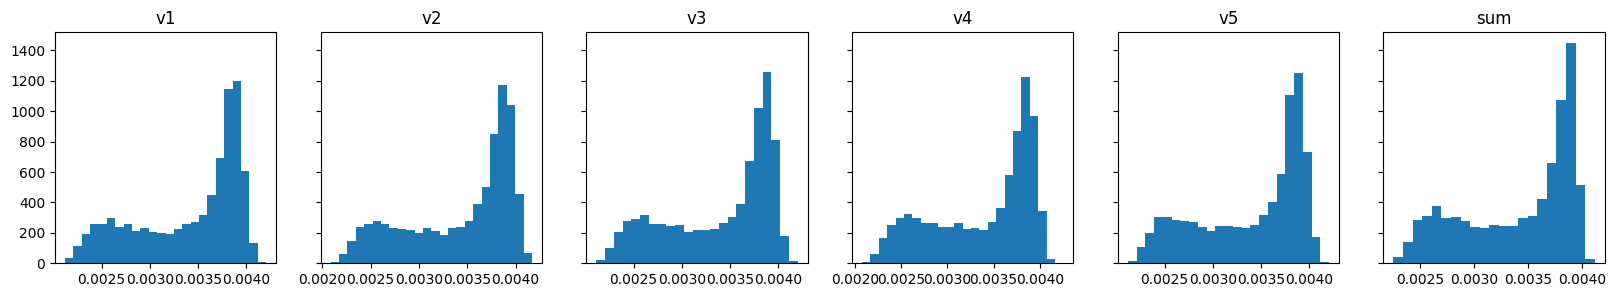

In [ ]:
# Plot

import numpy as np
import pickle 
with open('ensemble_outs.pkl', 'rb') as f:
    predictions = pickle.load(f)

model_paths = [
    "./d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v1.ckpt",
    "./d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v2.ckpt",
    "./d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v3.ckpt",
    "./d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v4.ckpt",
    "./d_model=240, nhead=6, comformer_with_layer_norm, layers=4, self_attention_pooling_2, no_pred_layer, AMS_loss_2_with_norm, m=0.325, lr=0.001, transformer_milestone_scheduler, warmup_steps=5k, start_milestones=35k, total_steps=70k, padding=1e-20, v5.ckpt",
]

confidences = []
for feat_path, prediction in predictions.items():
    arr = np.array(prediction)
    confs = np.amax(arr, axis=1)
    conf = confs.sum() / confs.shape[0]
    confidences.append((*confs, conf))
    

import matplotlib.pyplot as plt

confidences = np.array(confidences).T

fig, axs = plt.subplots(1, confidences.shape[0], sharey=True, figsize=(20, 3))

# We can set the number of bins with the *bins* keyword argument.
for idx, confidence in enumerate(confidences):
    axs[idx].hist(confidence, bins="auto")
    if idx < len(model_paths):
        axs[idx].set_title(model_paths[idx][-7:-5])
    else:
        axs[idx].set_title("sum")

[Info]: Use cuda now!
[Info]: Finish loading data!
[Info]: Finish creating model!


100%|██████████| 2000/2000 [01:33<00:00, 21.29it/s]


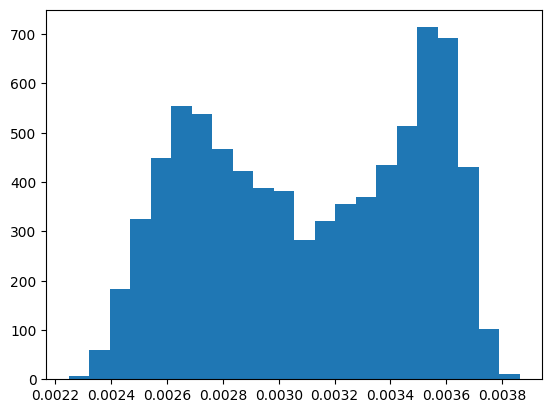

In [36]:
# Basic

import json
import csv
from pathlib import Path
from tqdm import tqdm

from conformer import Conformer as RealComformer


import torch
from torch.utils.data import DataLoader

def parse_args():
	"""arguments"""
	config = {
		"data_dir": "./Dataset",
		"model_path": "./d_model=100, nhead=4, comformer2_conv_2, drops, layers=12, self_attention_pooling_2, pred_layer_n=2, AMS_loss_2_with_norm, m=0.2, s=30, lr=0.001, milestone_sch_decay=0.85, batch_n=64, warmup_steps=7.5k, start_milestones=30k, total_steps=100k.ckpt",
		"output_path": "./output.csv",
		"batch_size": 4
	}

	return config


def main(
	data_dir,
	model_path,
	output_path,
	batch_size
):
	"""Main function."""
	device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
	print(f"[Info]: Use {device} now!")

	mapping_path = Path(data_dir) / "mapping.json"
	mapping = json.load(mapping_path.open())

	dataset = InferenceDataset(data_dir)
	dataloader = DataLoader(
		dataset,
		batch_size=batch_size,
		shuffle=False,
		drop_last=False,
		num_workers=4,
		collate_fn=inference_collate_batch,
	)
	print(f"[Info]: Finish loading data!", flush = True)

	speaker_num = len(mapping["id2speaker"])
	# model = Comformer(d_model=144, nhead=4, comformer_layers=8, n_spks=speaker_num).to(device)
	# model = Comformer(d_model=240, nhead=6, comformer_layers=4, n_spks=speaker_num).to(device)
	model = ComformerAMSLoss2(comformer_v=2, m=0.2, ams_s=30, d_model=100, ams_weight_norm=True, ams_feat_norm=True, pred_layer=2, nhead=4, comformer_layers=12, n_spks=speaker_num, norm_after_cf_block=False).to(device)


	# model = RComformer(num_classes=speaker_num, input_dim=40, encoder_dim=240, num_attention_heads=6, num_encoder_layers=4).to(device)
	model.load_state_dict(torch.load(model_path)["model_state_dict"])
	model.eval()
	print(f"[Info]: Finish creating model!",flush = True)

	results = [["Id", "Category"]]
	confidence = []
	for feat_paths, mels in tqdm(dataloader):
		with torch.no_grad():
			mels = mels.to(device)
			dummy_label = torch.zeros((batch_size,)).long().to(device)
			# outs = model(mels)
			outs, _ = model(mels, dummy_label)
			outs = nn.functional.softmax(outs, dim=1)
			preds = outs.argmax(1).cpu().numpy()
			confidences = outs.amax(1).cpu().numpy()
			for feat_path, pred, conf in zip(feat_paths, preds, confidences):
				results.append([feat_path, mapping["id2speaker"][str(pred)]])
				confidence.append(conf)

	with open(output_path, 'w', newline='') as csvfile:
		writer = csv.writer(csvfile)
		writer.writerows(results)

	import matplotlib.pyplot as plt

	fig, ax = plt.subplots(1, 1)

	# We can set the number of bins with the *bins* keyword argument.
	ax.hist(confidence, bins="auto")

main(**parse_args())